In [4]:
import matplotlib.pyplot as plt
import nltk
from nltk import tokenize
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import re
import seaborn as sns
import string
from collections import Counter
from wordcloud import WordCloud

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ruslanishakov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ruslanishakov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ruslanishakov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ruslanishakov/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [15]:
from tqdm.notebook import tqdm_notebook

tqdm_notebook().pandas()

0it [00:00, ?it/s]

In [5]:
pickl_h_train = pd.read_pickle('dataset/outfox/human/train_humans.pkl')
pickl_h_test = pd.read_pickle('dataset/outfox/human/test_humans.pkl')
pickl_h_valid = pd.read_pickle('dataset/outfox/human/valid_humans.pkl')
df_human_test = pd.DataFrame(pickl_h_test)
df_human_train = pd.DataFrame(pickl_h_train)
df_human_valid = pd.DataFrame(pickl_h_valid)
df_human = pd.concat([df_human_train, df_human_test, df_human_valid], ignore_index=True)
df_human.rename(columns={0: 'text'}, inplace=True)
df_human['generated'] = 0
df_human

,text,generated
0,Driverless cars have always been seen and thou...,0
1,The Electoral College is only taking your pers...,0
2,Distance learning recently started being consi...,0
3,Distractions while driving could lead to death...,0
4,Would having car free cities be easier for eve...,0
...,...,...
15395,"Should students have classes from home, base i...",0
15396,Driveress cars are in our future because of al...,0
15397,Are dreiverless cars a good idea for the futur...,0
15398,Sometimes school can be to much for a person. ...,0


In [6]:
pickl_flan_train = pd.read_pickle('dataset/outfox/flan_t5/train_lms_flan.pkl')
pickl_flan_test = pd.read_pickle('dataset/outfox/flan_t5/test_lms_flan.pkl')
pickl_flan_valid = pd.read_pickle('dataset/outfox/flan_t5/valid_lms_flan.pkl')
df_flan_train = pd.DataFrame(pickl_flan_train)
df_flan_test = pd.DataFrame(pickl_flan_test)
df_flan_valid = pd.DataFrame(pickl_flan_valid)
df_flan = pd.concat([df_flan_train, df_flan_test, df_flan_valid], ignore_index=True)
df_flan.rename(columns={0: 'text'}, inplace=True)
df_flan['generated'] = 1
df_flan

,text,generated
0,Driverless motoring seems to be coming all of ...,1
1,Several factors that contributed to its declin...,1
2,The most obvious benefit of distance learning ...,1
3,There are millions every quarter that decide o...,1
4,Many cities offer traffic bans during differen...,1
...,...,...
15395,It is hard for students to follow their class ...,1
15396,This kind of software and technology used in c...,1
15397,Driverless cars would drastically reduce the a...,1
15398,Online classes require the use of computer and...,1


In [7]:
df = pd.concat([df_human, df_flan], ignore_index=True)

In [9]:
df

,text,generated
0,Driverless cars have always been seen and thou...,0
1,The Electoral College is only taking your pers...,0
2,Distance learning recently started being consi...,0
3,Distractions while driving could lead to death...,0
4,Would having car free cities be easier for eve...,0
...,...,...
30795,It is hard for students to follow their class ...,1
30796,This kind of software and technology used in c...,1
30797,Driverless cars would drastically reduce the a...,1
30798,Online classes require the use of computer and...,1


In [10]:
df['generated'].value_counts()

0    15400
1    15400
Name: generated, dtype: int64

In [11]:
df[df.duplicated(keep=False) == True]['generated'].value_counts()

0    170
Name: generated, dtype: int64

In [12]:
df = df.drop_duplicates()
df

,text,generated
0,Driverless cars have always been seen and thou...,0
1,The Electoral College is only taking your pers...,0
2,Distance learning recently started being consi...,0
3,Distractions while driving could lead to death...,0
4,Would having car free cities be easier for eve...,0
...,...,...
30795,It is hard for students to follow their class ...,1
30796,This kind of software and technology used in c...,1
30797,Driverless cars would drastically reduce the a...,1
30798,Online classes require the use of computer and...,1


In [13]:
def tokenize_and_clean_text(text):
    tokens = tokenize.word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    punct_chars = string.punctuation + "'s" + '""' + '...' + "''" + '``'
    filtered_tokens = [word.lower() for word in tokens if word not in stop_words and word not in punct_chars]
    return filtered_tokens

def lemmatize(tokens):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

def get_mean_sent_char_length(sent_tokens):
    return np.mean([len(sent) for sent in sent_tokens])

def get_mean_sent_word_length(sent_tokens):
    return np.mean([len(sent.split()) for sent in sent_tokens])

def new_lines_quantity(text):
    pattern = r'(\n)'
    matches = re.findall(pattern, text)
    return len(matches)

In [16]:
df['BoW_raw'] = df['text'].progress_apply(tokenize_and_clean_text)

  0%|          | 0/30715 [00:00<?, ?it/s]

/var/folders/qr/1czxs48x1jx3pgl16wbvvqwm0000gn/T/ipykernel_8889/1126705616.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BoW_raw'] = df['text'].progress_apply(tokenize_and_clean_text)


In [17]:
df.loc[:, 'text_length'] = df['BoW_raw'].apply(lambda x: len(x))

/Users/ruslanishakov/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [19]:
df.loc[:, 'average_word_length'] = df['BoW_raw'].apply(lambda x: np.mean([len(word) for word in x if word.isalpha()]))

In [20]:
print(df['text_length'].min())
print(df['text_length'].max())
print(df['text_length'].mean())

12
754
202.14419664658962


In [21]:
df.loc[:, 'text_sent_length'] = df.loc[:, 'text'].progress_apply(tokenize.sent_tokenize).apply(len)

  0%|          | 0/30715 [00:00<?, ?it/s]

In [22]:
df.loc[:,'mean_sentence_length_chars'] = df['text'].progress_apply(tokenize.sent_tokenize).apply(get_mean_sent_char_length)

  0%|          | 0/30715 [00:00<?, ?it/s]

In [23]:
df.loc[:, 'mean_sentence_length_words'] = df['text'].progress_apply(tokenize.sent_tokenize).apply(get_mean_sent_word_length)

  0%|          | 0/30715 [00:00<?, ?it/s]

In [24]:
df['BoW_lemmatized'] = df['BoW_raw'].progress_apply(lemmatize)

  0%|          | 0/30715 [00:00<?, ?it/s]

/var/folders/qr/1czxs48x1jx3pgl16wbvvqwm0000gn/T/ipykernel_8889/3186995282.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BoW_lemmatized'] = df['BoW_raw'].progress_apply(lemmatize)


In [25]:
df.loc[:, 'tokens_num'] = df.loc[:, 'BoW_lemmatized'].apply(len).astype('int16')

In [26]:
df.loc[:, 'unique_words'] = df.loc[:, 'BoW_raw'].apply(lambda x: len(set(x)))
df.loc[:, 'unique_ratio'] = df.loc[:, 'unique_words'] / df.loc[:, 'BoW_raw'].apply(len)

In [27]:
df.loc[:, 'new_lines_quant'] = df.loc[:, 'text'].apply(new_lines_quantity)

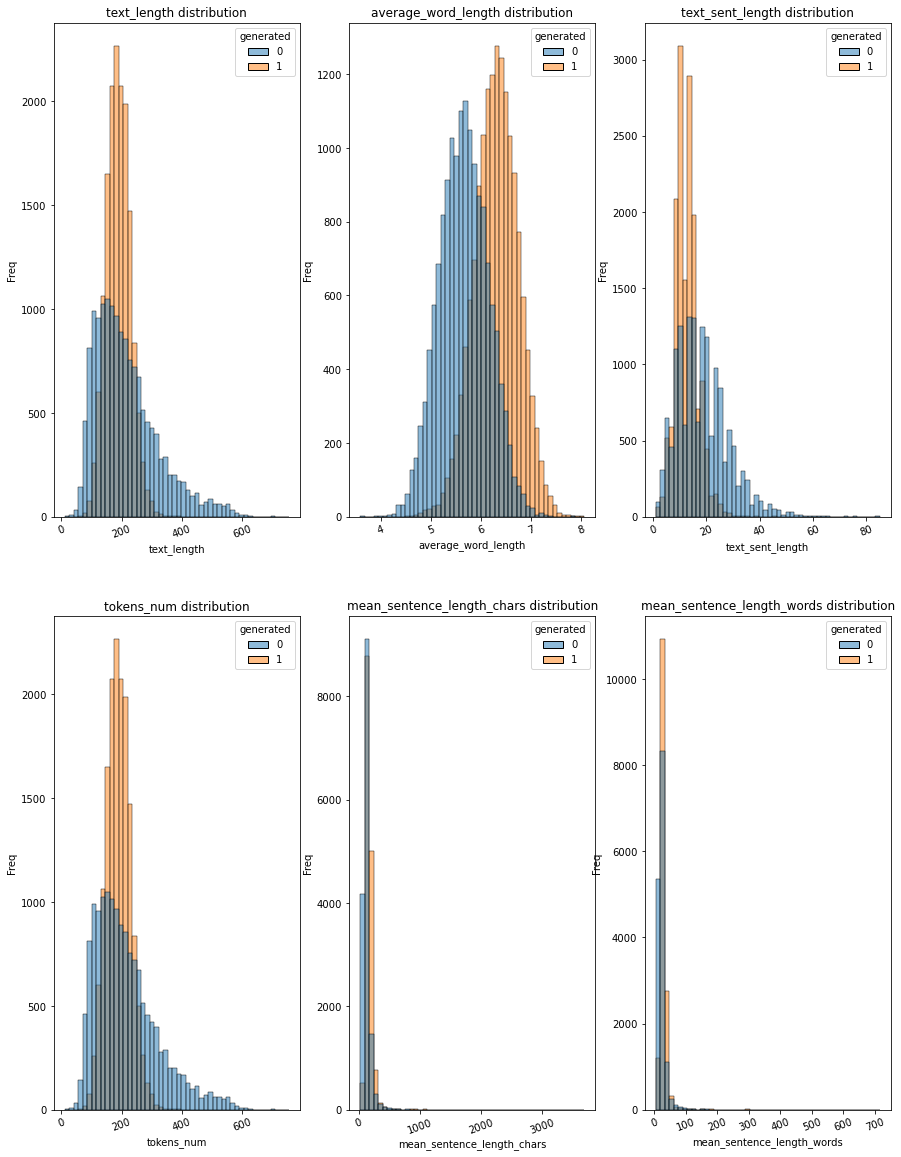

In [28]:
num_cols = df[['text_length', 'average_word_length', 'text_sent_length', 'tokens_num', 'mean_sentence_length_chars', 'mean_sentence_length_words']].columns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 20))
for ax, col in zip(axes.flatten(), num_cols):
    sns.histplot(data=df, x=df[col], hue='generated', ax=ax, bins=50)
    ax.set_title(f'{col} distribution')
    ax.set_xlabel(f'{col}')
    ax.set_ylabel('Freq')
    ax.tick_params(axis='x', labelrotation=20)

In [30]:
print(df[df['generated'] == 0]['text_length'].skew())
print(df[df['generated'] == 1]['text_length'].skew())

1.08573259812123
0.27404846934555754


In [32]:
print(df[df['generated'] == 0]['text_sent_length'].skew())
print(df[df['generated'] == 1]['text_sent_length'].skew())

0.9563172817561583
0.7722488564919353


In [31]:
print(df[df['generated'] == 0]['text_length'].kurtosis())
print(df[df['generated'] == 1]['text_length'].kurtosis())

1.097144347395175
0.3476119285807959


In [33]:
print(df[df['generated'] == 0]['text_sent_length'].kurtosis())
print(df[df['generated'] == 1]['text_sent_length'].kurtosis())

1.674378569219753
2.3918249996858703


In [41]:
pd.options.display.float_format = '{:,.2f}'.format

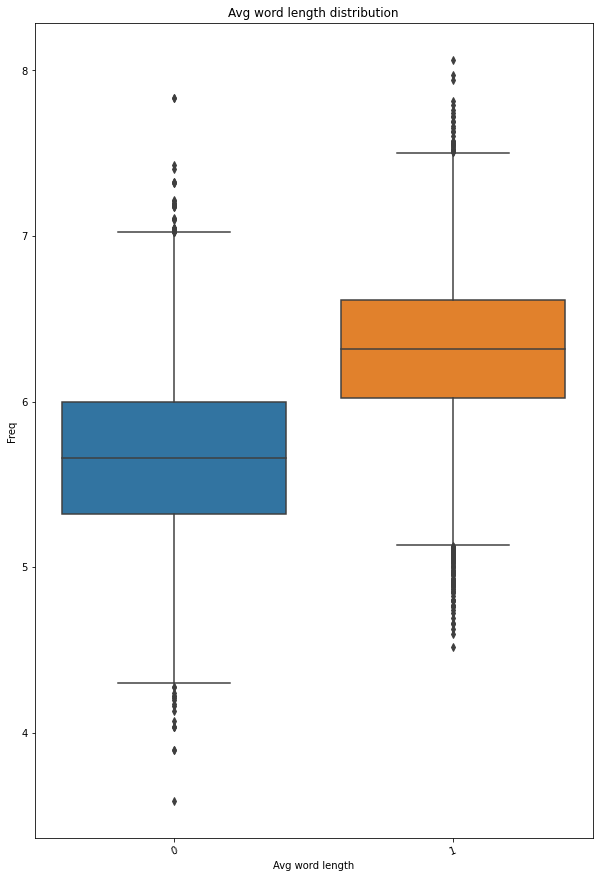

In [44]:
fig, ax = plt.subplots(figsize=(10, 15))
sns.boxplot(data=df, x='generated', y='average_word_length', ax=ax)
ax.set_title(f'Avg word length distribution')
ax.set_xlabel(f'Avg word length')
ax.set_ylabel('Freq')
ax.tick_params(axis='x', labelrotation=20)

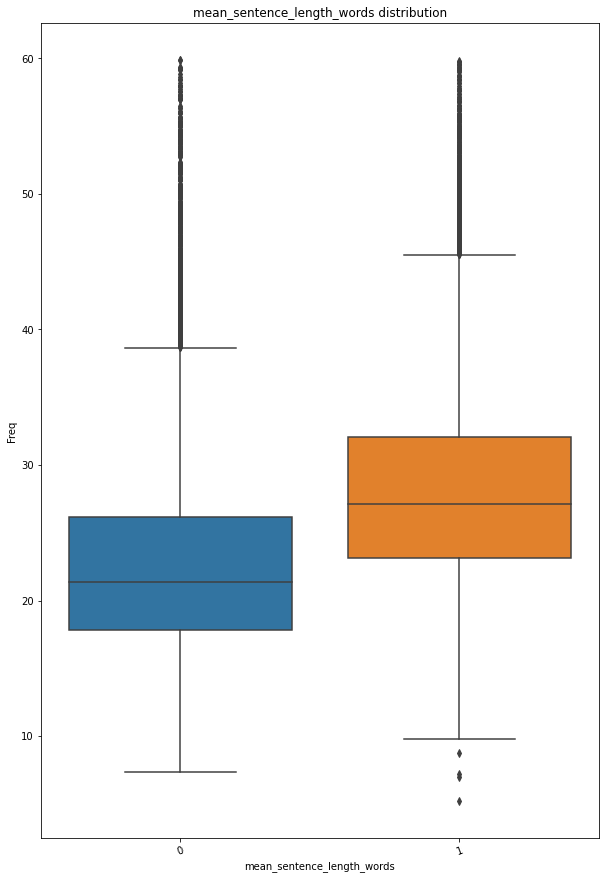

In [53]:
# Outliers > 60 are removed from boxplot
fig, ax = plt.subplots(figsize=(10, 15))
sns.boxplot(data=df, x='generated', y=df[df['mean_sentence_length_words'] < 60]['mean_sentence_length_words'], ax=ax)
ax.set_title(f'mean_sentence_length_words distribution')
ax.set_xlabel(f'mean_sentence_length_words')
ax.set_ylabel('Freq')
ax.tick_params(axis='x', labelrotation=20)

In [54]:
cnt = Counter()
df['BoW_raw'].progress_apply(lambda x: ''.join(x)).progress_apply(cnt.update)
cnt

  0%|          | 0/30715 [00:00<?, ?it/s]

  0%|          | 0/30715 [00:00<?, ?it/s]

Counter({'d': 1411143,
         'r': 2247419,
         'i': 2750646,
         'v': 566897,
         'e': 4960838,
         'l': 2033930,
         's': 2883770,
         'c': 1600419,
         'a': 2617688,
         'w': 489438,
         'y': 648468,
         'n': 2637866,
         't': 2881722,
         'h': 1000762,
         'o': 2537430,
         'u': 1171671,
         'g': 995449,
         'm': 987231,
         'p': 1062861,
         'j': 59389,
         'k': 373256,
         'f': 530041,
         'b': 399313,
         'x': 101323,
         'z': 25435,
         '2': 18813,
         '-': 44403,
         '.': 16818,
         '3': 9400,
         '1': 21825,
         "'": 50706,
         '9': 9771,
         '_': 4017,
         '6': 6190,
         '7': 6478,
         'q': 35397,
         '5': 9518,
         '0': 33886,
         ',': 2465,
         '/': 5407,
         '4': 6780,
         '8': 6460,
         '´': 195,
         '~': 3,
         '\x92': 89,
         'ã': 121,
         '\x82'

In [55]:
cnt_lemm = Counter()
df['BoW_lemmatized'].progress_apply(cnt_lemm.update)
lemm_unigramms = cnt_lemm.most_common()
lemm_unigramms

  0%|          | 0/30715 [00:00<?, ?it/s]

[('student', 104673),
 ('school', 70251),
 ('people', 66029),
 ('would', 62545),
 ('car', 55155),
 ('i', 52894),
 ('the', 47699),
 ('one', 42122),
 ('time', 39677),
 ('make', 37194),
 ('could', 35950),
 ('get', 35432),
 ("n't", 35013),
 ('many', 32958),
 ('help', 32094),
 ('also', 31885),
 ('may', 28847),
 ('like', 28537),
 ('class', 28386),
 ('even', 27890),
 ('state', 27520),
 ('vote', 27168),
 ('way', 26675),
 ('work', 25269),
 ('need', 24930),
 ('phone', 24839),
 ('teacher', 24109),
 ('this', 23781),
 ('take', 22744),
 ('life', 22643),
 ('think', 21793),
 ('use', 21779),
 ('learning', 21587),
 ('it', 21553),
 ('college', 21173),
 ('electoral', 20989),
 ('project', 20777),
 ('thing', 20764),
 ('in', 20622),
 ('better', 19690),
 ('good', 18827),
 ('driving', 18607),
 ('want', 18393),
 ('go', 18280),
 ('if', 18259),
 ('online', 17846),
 ('activity', 17512),
 ('home', 17500),
 ('system', 17299),
 ('know', 17139),
 ('a', 16436),
 ('human', 16151),
 ('person', 16087),
 ('new', 15543),
 (

In [56]:
cnt_lemm.most_common(20)

[('student', 104673),
 ('school', 70251),
 ('people', 66029),
 ('would', 62545),
 ('car', 55155),
 ('i', 52894),
 ('the', 47699),
 ('one', 42122),
 ('time', 39677),
 ('make', 37194),
 ('could', 35950),
 ('get', 35432),
 ("n't", 35013),
 ('many', 32958),
 ('help', 32094),
 ('also', 31885),
 ('may', 28847),
 ('like', 28537),
 ('class', 28386),
 ('even', 27890)]

In [57]:
unigrams = {key: value for key, value in lemm_unigramms}
unigrams

{'student': 104673,
 'school': 70251,
 'people': 66029,
 'would': 62545,
 'car': 55155,
 'i': 52894,
 'the': 47699,
 'one': 42122,
 'time': 39677,
 'make': 37194,
 'could': 35950,
 'get': 35432,
 "n't": 35013,
 'many': 32958,
 'help': 32094,
 'also': 31885,
 'may': 28847,
 'like': 28537,
 'class': 28386,
 'even': 27890,
 'state': 27520,
 'vote': 27168,
 'way': 26675,
 'work': 25269,
 'need': 24930,
 'phone': 24839,
 'teacher': 24109,
 'this': 23781,
 'take': 22744,
 'life': 22643,
 'think': 21793,
 'use': 21779,
 'learning': 21587,
 'it': 21553,
 'college': 21173,
 'electoral': 20989,
 'project': 20777,
 'thing': 20764,
 'in': 20622,
 'better': 19690,
 'good': 18827,
 'driving': 18607,
 'want': 18393,
 'go': 18280,
 'if': 18259,
 'online': 17846,
 'activity': 17512,
 'home': 17500,
 'system': 17299,
 'know': 17139,
 'a': 16436,
 'human': 16151,
 'person': 16087,
 'new': 15543,
 'able': 15008,
 'advice': 14992,
 'might': 14706,
 'venus': 14613,
 'well': 14552,
 'something': 14321,
 'muc

In [58]:
def get_words_as_text(tokens):
    return ' '.join(tokens)

In [59]:
words = df['BoW_raw'].apply(get_words_as_text)
words_as_texts = ' '.join(words)
all_words = words_as_texts.split()

In [60]:
bigrams = nltk.ngrams(all_words, 2)
cnt_bigrams = Counter(bigrams)
bigr = cnt_bigrams.most_common()

In [61]:
bigrams_freq = {' '.join(key): value for key, value in bigr}
bigrams_freq

{'electoral college': 15568,
 'driverless cars': 7916,
 'i think': 7570,
 'community service': 6812,
 'cell phones': 6403,
 'for example': 4907,
 'popular vote': 4826,
 'distance learning': 4424,
 'cell phone': 4217,
 'united states': 4131,
 'many people': 4106,
 'online classes': 3803,
 'one person': 3709,
 'the electoral': 3533,
 'high school': 3465,
 'students would': 3437,
 'i believe': 3390,
 "ca n't": 3214,
 'summer projects': 3010,
 'extracurricular activities': 2928,
 "would n't": 2852,
 'i would': 2829,
 'even though': 2526,
 'classes home': 2496,
 'many students': 2461,
 'driverless car': 2406,
 'multiple people': 2386,
 "wo n't": 2361,
 'seagoing cowboys': 2307,
 'electoral votes': 2201,
 'face mars': 2186,
 'multiple opinions': 2026,
 'in conclusion': 1971,
 'make sure': 1944,
 'extracurricular activity': 1874,
 'car usage': 1867,
 'texting driving': 1807,
 'vote president': 1758,
 'help students': 1743,
 'students may': 1736,
 "i n't": 1699,
 'use cell': 1689,
 'facial act

In [62]:
trigrams = nltk.ngrams(all_words, 3)
cnt_trigrams = Counter(trigrams)
trigr = cnt_trigrams.most_common()

In [63]:
trigrams_freq = {' '.join(key): value for key, value in trigr}
trigrams_freq

{'the electoral college': 3256,
 'facial action coding': 1549,
 'action coding system': 1338,
 'use cell phones': 1309,
 'attend classes home': 1153,
 'electoral college system': 1115,
 'limiting car usage': 830,
 'cell phone use': 755,
 'make better choice': 749,
 'cell phones school': 731,
 'seeking multiple opinions': 722,
 'ask one person': 713,
 'students would benefit': 694,
 'seagoing cowboys program': 657,
 'electoral college unfair': 631,
 'president united states': 625,
 'able attend classes': 612,
 'the face mars': 558,
 'online video conferencing': 557,
 'election popular vote': 544,
 'i think students': 533,
 'asking multiple people': 533,
 'driverless cars would': 523,
 'ask multiple people': 522,
 'benefit able attend': 514,
 'one person advice': 510,
 "i n't think": 501,
 'keep electoral college': 496,
 'asking one person': 489,
 'multiple people advice': 484,
 'multiple opinions help': 473,
 'one extracurricular activity': 457,
 'high school students': 444,
 'venus wor

In [64]:
def get_pos(tokens):
    return [tag for word, tag in nltk.pos_tag(tokens, lang='eng')]

In [65]:
cnt_pos = Counter()
df['BoW_raw'].progress_apply(get_pos).apply(cnt_pos.update)
pos_count = cnt_pos.most_common()
pos_count

  0%|          | 0/30715 [00:00<?, ?it/s]

[('NN', 1737809),
 ('JJ', 988737),
 ('NNS', 878780),
 ('RB', 431841),
 ('VBP', 386590),
 ('VBG', 310668),
 ('VB', 281950),
 ('IN', 204857),
 ('MD', 159368),
 ('VBD', 153170),
 ('VBZ', 123752),
 ('DT', 121284),
 ('VBN', 113837),
 ('CD', 103940),
 ('PRP', 61739),
 ('JJR', 39006),
 ('JJS', 20485),
 ('RBR', 20250),
 ('CC', 15930),
 ('WRB', 13263),
 ('PRP$', 5604),
 ('RP', 5088),
 ('NNP', 5005),
 ('TO', 4864),
 ('WDT', 4324),
 ('WP', 4184),
 ('EX', 3828),
 ('RBS', 2538),
 ('FW', 2044),
 (':', 1427),
 ('POS', 982),
 ('WP$', 686),
 ('UH', 331),
 ('PDT', 317),
 ('$', 175),
 ('NNPS', 130),
 ("''", 45),
 ('SYM', 31)]

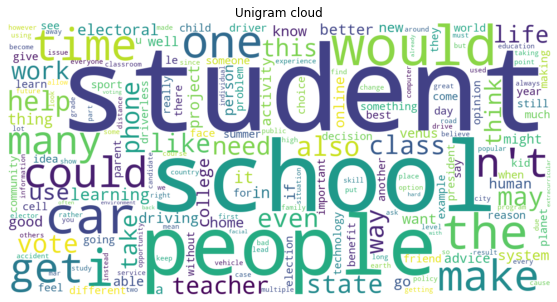

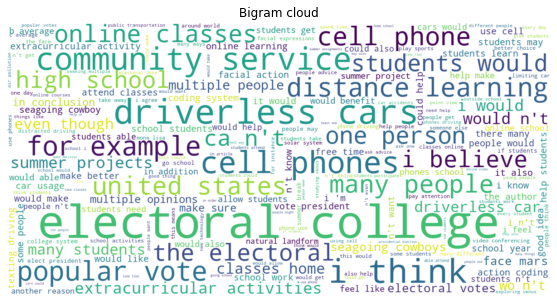

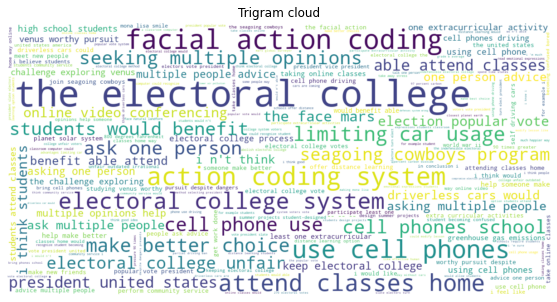

In [66]:
frequencies = unigrams, bigrams_freq, trigrams_freq
for feature in frequencies:
    wordcloud = WordCloud(width=1200, height=600, background_color='white').generate_from_frequencies(feature)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    if feature == unigrams:
        plt.title('Unigram cloud')
    elif feature == bigrams_freq:
        plt.title('Bigram cloud')
    else:
        plt.title('Trigram cloud')
    plt.axis('off')
    plt.show()

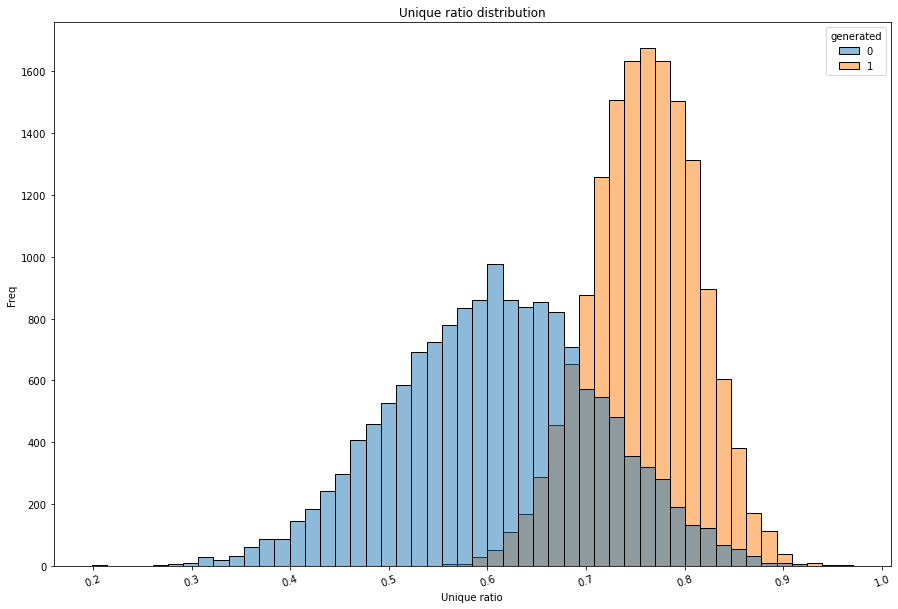

In [67]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.histplot(data=df, x='unique_ratio', hue='generated', ax=ax, bins=50)
ax.set_title(f'Unique ratio distribution')
ax.set_xlabel(f'Unique ratio')
ax.set_ylabel('Freq')
ax.tick_params(axis='x', labelrotation=20)

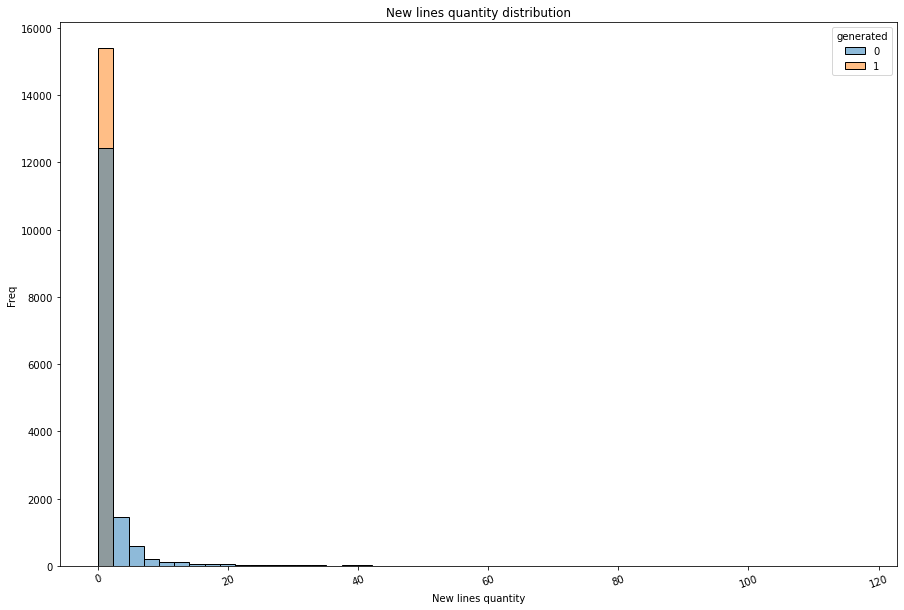

In [68]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.histplot(data=df, x='new_lines_quant', hue='generated', ax=ax, bins=50)
ax.set_title(f'New lines quantity distribution')
ax.set_xlabel(f'New lines quantity')
ax.set_ylabel('Freq')
ax.tick_params(axis='x', labelrotation=20)